# Baseline models for SST paper
* autoencoder
* vwmhqae
* LSTM

# 1. SST model

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from math import exp
import time
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda, Layer, Dropout
from tensorflow.keras.initializers import Constant
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import pytz
from datetime import datetime
import os
import csv
import sys
from scipy.stats import mode
import matplotlib.pyplot as plt

In [ ]:
# hyper parameters
reg_kernal = 1e-4
#reg_activity = 1e-4
kernel_regularizer=tf.keras.regularizers.l2(reg_kernal)
#activity_regularizer=tf.keras.regularizers.l2(reg_activity)
#kernel_regularizer=None
activity_regularizer=None
  
earlystop_callback = tf.keras.callbacks.EarlyStopping(
  monitor='val_loss', min_delta=0.0001,
  patience=100,restore_best_weights=True)

variance_on = False
single_meas = False

# hyper parameters
num_layers = 3

d_model=128
dff = 128
num_heads = 1
dropout_rate = 0.5
lr = 1e-4
lr_factor = 0.5
warmup = 4000

epochs = 1000
batch_size = 2048
wafer_col = 'substrate'

model_name = 'layer_%s_dff_%s_head_%s_kernel_%s_act_%s_drop_%s_epoch_%s_batch_%s_dmodel_%s_lrf_%s'%(num_layers, 
                   dff, num_heads, reg_kernal, reg_activity, dropout_rate, epochs, batch_size, d_model,lr_factor)

if variance_on:
    model_name += '_vw'
model_name += '_embed'
model_name

## read and process the data

In [61]:
tool_set = 'P1'
grouping = 'time_step'
experiment = 'SST'

In [62]:
np_path = 'npdata/%s/'%(tool_set)
X_train = np.load(np_path+'X_train.npy')
X_val = np.load(np_path+'X_val.npy')
X_test = np.load(np_path+'X_test.npy')
label_train = np.load(np_path+'label_train.npy')
label_val = np.load(np_path+'label_val.npy')
label_test = np.load(np_path+'label_test.npy')
label_cols = np.array(range(label_train.shape[1]//2))

X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_val = tf.convert_to_tensor(X_val, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
label_train = tf.convert_to_tensor(label_train, dtype=tf.float32)
label_val = tf.convert_to_tensor(label_val, dtype=tf.float32)
label_test = tf.convert_to_tensor(label_test, dtype=tf.float32)

In [63]:
print(X_train.shape, X_val.shape, X_test.shape)
print(label_train.shape, label_val.shape, label_test.shape)

(194042, 2, 817) (34122, 2, 817) (27326, 2, 817)
(194042, 22) (34122, 22) (27326, 22)


## class weight

In [64]:
class_weight = np.array([label_train.shape[0]/label_train.shape[1]/label_train.numpy()[:,i].sum() for i in range(label_train.shape[1])])

class_weight

array([1.46513138e+00, 3.24268048e+01, 8.57318323e-01, 2.67275482e+02,
       2.05170879e-01, 4.41004545e+01, 7.93601845e-01, 6.68188705e+01,
       2.68954410e-01, 2.06076890e+01, 1.37798849e-01, 1.24401846e+01,
       7.51720836e-02, 5.18219207e+00, 5.04581860e+00, 1.99099118e+01,
       3.93402806e-01, 1.02559197e+02, 1.12015379e+00, 1.83751894e+02,
       2.45863046e-01, 3.88550260e+01])

In [65]:
def loss_func(w):
    def inner_loss(y,y_pred):
        loss = 0
        weights = w
        
        for i in range(len(weights)//2):
            
            y_i = y[:,2*i:2*i+2]
            y_pred_i = y_pred[:,2*i:2*i+2]
            w_i = weights[2*i:2*i+2]
            #y_pred_i /= tf.reduce_sum(y_pred_i, axis=1, keepdims=True)
            y_pred_i = tf.nn.softmax(y_pred_i,axis=1)
            loss_category = -tf.reduce_mean(y_i*tf.math.log(tf.clip_by_value(y_pred_i,1e-10,1.0)),axis=0)
            loss_i = tf.reduce_sum(loss_category*w_i)
            
            loss += loss_i

        return loss
    return inner_loss

## The transformer model

In [66]:
# positional encoding
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

# masking
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq[:,:,-1], 1), tf.float32)

    # add extra dimensions to add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

In [67]:
# attention
def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model,activity_regularizer=activity_regularizer, kernel_regularizer=kernel_regularizer)
        self.wk = tf.keras.layers.Dense(d_model,activity_regularizer=activity_regularizer, kernel_regularizer=kernel_regularizer)
        self.wv = tf.keras.layers.Dense(d_model,activity_regularizer=activity_regularizer, kernel_regularizer=kernel_regularizer)

        self.dense = tf.keras.layers.Dense(d_model,activity_regularizer=activity_regularizer, kernel_regularizer=kernel_regularizer)

    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention, 
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights

In [68]:
# feed forward
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu',
                            activity_regularizer=activity_regularizer, kernel_regularizer=kernel_regularizer),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model,
                            activity_regularizer=activity_regularizer, kernel_regularizer=kernel_regularizer)  # (batch_size, seq_len, d_model)
    ])

In [69]:
#encoder
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):

        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

        return out2
    
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                                self.d_model)


        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):

        seq_len = tf.shape(x)[1]

        # adding embedding and position encoding.
        # x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x  # (batch_size, input_seq_len, d_model)

# Training

Variance weighted model

In [70]:
class CustomMultiLossLayer(Layer):
    def __init__(self, nb_outputs, **kwargs):
        self.nb_outputs = nb_outputs # nb_outputs = 2*#meas_steps
        self.is_placeholder = True
        super(CustomMultiLossLayer, self).__init__(**kwargs)
        
    def build(self, input_shape=None):
        # initialise log_vars
        self.log_vars = []
        for i in range(self.nb_outputs):
            self.log_vars += [self.add_weight(name='log_var' + str(i), shape=(1,),
                                              initializer=Constant(0.), trainable=variance_on)]
        super(CustomMultiLossLayer, self).build(input_shape)

    def multi_loss(self, y_true, y_pred, weights):
        loss = 0        
        # cross-entropy part
        for i in range(self.nb_outputs//2):
            
            y_i = y_true[:,2*i:2*i+2]
            y_pred_i = y_pred[:,2*i:2*i+2]
            w_i = weights[2*i:2*i+2]
            # y_pred_i /= tf.reduce_sum(y_pred_i, axis=1, keepdims=True)
            y_pred_i = tf.nn.softmax(y_pred_i,axis=1)
            loss_category = -tf.reduce_mean(y_i*tf.math.log(tf.clip_by_value(y_pred_i,1e-10,1.0)),axis=0)
            loss_category*=w_i
            vw = self.log_vars[2*i:2*i+2]
            p1, p2 = K.exp(-vw[0][0]*2), K.exp(-vw[1][0]*2)
            loss_i = p1*loss_category[0] + vw[0][0] + p2*loss_category[1] + vw[1][0]
            
            # sigma = self.log_vars[i][0]
            # loss_i = K.exp(-sigma*2)*loss_category[0] + sigma + K.exp(-sigma*2)*loss_category[1] + sigma
            # loss_i = K.exp(-2*sigma)*tf.reduce_sum(loss_category) + sigma
            # loss_i += (p1+p2)*1e-10
            
            loss += loss_i
        
        return loss

    def call(self, inputs, weights):
        y_true = inputs[0]
        y_pred = inputs[1]
        loss = self.multi_loss(y_true, y_pred, weights)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return y_pred

In [71]:
def get_sst_model(inp_dim1, inp_dim2, out_dim, weights, num_layers, d_model, num_heads, dff, 
                input_vocab_size, target_vocab_size, pe_input, rate):
    inp = Input(shape=(inp_dim1, inp_dim2,))
    tokenizer = Encoder(num_layers, d_model, num_heads, dff, 
                        input_vocab_size, pe_input, rate)
    #final_layer = Dense(target_vocab_size, activation='sigmoid',
    #                    activity_regularizer=activity_regularizer, kernel_regularizer=kernel_regularizer)
    final_layer = tf.keras.Sequential([Dense(dff, activation='sigmoid',
                                activity_regularizer=activity_regularizer, kernel_regularizer=kernel_regularizer),
                                tf.keras.layers.Dropout(rate),
                                Dense(dff, activation='sigmoid',
                                activity_regularizer=activity_regularizer, kernel_regularizer=kernel_regularizer),
                                tf.keras.layers.Dropout(rate),
                                tf.keras.layers.Dense(target_vocab_size, activation='sigmoid',
                                activity_regularizer=activity_regularizer, kernel_regularizer=kernel_regularizer)])
    enc_padding_mask = create_padding_mask(inp)
    embed = tf.keras.layers.Dense(d_model)(inp)
    enc_output = tokenizer(embed, True, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
    dec_output = layers.GlobalAveragePooling1D()(enc_output) # to do: change to flatten (need to support masking)
    y_pred = final_layer(dec_output)
    
    y_true = Input(shape=(out_dim,), name='y_true')
    out = CustomMultiLossLayer(nb_outputs=out_dim)([y_true, y_pred],weights)
    return Model([inp, y_true], out)

In [72]:
# learning rate decay
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=warmup):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2) * lr_factor
learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

In [73]:
inp_dim1 = X_train.shape[1]
inp_dim2 = X_train.shape[2]
out_dim= label_train.shape[1]
#input_vocab_size = d_model
#target_vocab_size 
out_dim= label_train.shape[1]
transformer = get_sst_model(
            inp_dim1 = inp_dim1,
            inp_dim2 = inp_dim2,
            out_dim = out_dim,
            weights = class_weight,
            num_layers=num_layers,
            d_model=d_model,
            num_heads=num_heads,
            dff=dff,
            input_vocab_size=d_model,
            target_vocab_size=out_dim,
            pe_input=1000,
            rate=dropout_rate)

In [74]:
transformer.compile(optimizer=optimizer, loss=None)
#transformer.compile(optimizer=tf.keras.optimizers.Adam(lr=lr), loss=None)

Epoch 1/1000
95/95 [==============================] - 4s 42ms/step - loss: 0.7015 - val_loss: 0.6273
Epoch 2/1000
95/95 [==============================] - 3s 27ms/step - loss: 0.7011 - val_loss: 0.6266
Epoch 3/1000
95/95 [==============================] - 3s 27ms/step - loss: 0.6988 - val_loss: 0.6256
Epoch 4/1000
95/95 [==============================] - 3s 27ms/step - loss: 0.6996 - val_loss: 0.6247
Epoch 5/1000
95/95 [==============================] - 3s 27ms/step - loss: 0.7016 - val_loss: 0.6239
Epoch 6/1000
95/95 [==============================] - 3s 27ms/step - loss: 0.6994 - val_loss: 0.6225
Epoch 7/1000
95/95 [==============================] - 3s 27ms/step - loss: 0.6985 - val_loss: 0.6216
Epoch 8/1000
95/95 [==============================] - 3s 27ms/step - loss: 0.6971 - val_loss: 0.6200
Epoch 9/1000
95/95 [==============================] - 3s 27ms/step - loss: 0.6979 - val_loss: 0.6171
Epoch 10/1000
95/95 [==============================] - 3s 27ms/step - loss: 0.6934 - val_lo

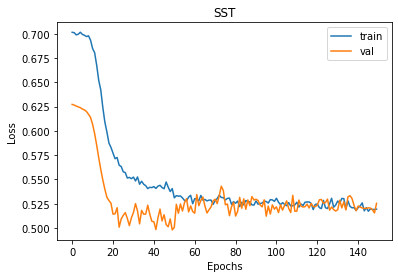

CPU times: user 13min 13s, sys: 44.1 s, total: 13min 57s
Wall time: 6min 33s


In [75]:
%%time
hist = transformer.fit([X_train, label_train],label_train,
                    epochs=epochs,
                    batch_size = batch_size, 
                    verbose=1,
                    callbacks=[earlystop_callback],
                    validation_data=([X_val,label_val], label_val))

# plot the loss
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='val')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.yscale('log')
plt.title(experiment)
plt.show()

In [76]:
print('weights:', [np.exp(-K.get_value(log_var[0])) for log_var in transformer.layers[-1].log_vars])
transformer.summary()

weights: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 2, 817)]     0                                            
__________________________________________________________________________________________________
tf_op_layer_strided_slice_2 (Te [(None, 2)]          0           input_4[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_Equal_1 (TensorFlow [(None, 2)]          0           tf_op_layer_strided_slice_2[0][0]
__________________________________________________________________________________________________
tf_op_layer_Cast_1 (TensorFlowO [(None, 2)]          0           tf_op_

# Evaluation

In [77]:
from sklearn.metrics import roc_curve,roc_auc_score
import matplotlib.pyplot as plt
def plot_roc_cur(fper, tper, title):  
    plt.plot(fper, tper, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-' + title)
    plt.legend()
    # plt.savefig(plots_folder + 'roc.png')
    plt.show()
    
    
def evaluate(classifier, X, label, label_cols, model_name, split_name, plot=False, save=True):
    thresh = 0.5
    label_pred = transformer.predict([X,label])
    label_true = label
    
    # softmax for pos/neg predictions
    for i in range(label_true.shape[1]//2):
        label_pred[:,2*i:2*i+2] = tf.nn.softmax(label_pred[:,2*i:2*i+2],axis=1)
        
    
    prob = label_pred*label_true
    
    print(split_name, ': the overall accuracy is:', sum(sum(prob.numpy()>thresh))/sum(sum(label.numpy()>0)))
    print(split_name, ': the overall recall is:', sum(sum(prob.numpy()>thresh)[1::2])/sum(sum(label.numpy()>0)[1::2]))
    
    meas_steps = label_cols
    result = pd.DataFrame(index=meas_steps, columns = ['model', 'split', 'tp','tn','fn','fp','tpr','fpr','min_dis', 'auc'])
    for i in range(len(meas_steps)):
        neg = prob[:,2*i]
        pos = prob[:,2*i+1]

        pos = pos[pos!=0].numpy()
        neg = neg[neg!=0].numpy()

        tp = sum(pos>thresh)
        fn = sum(pos<thresh)
        tn = sum(neg>thresh)
        fp = sum(neg<thresh)
        tpr = tp/(tp+fn+1e-9)
        fpr = fp/(fp+tn+1e-9)

        y_prob = np.append(pos, neg)
        y_true = np.append([1]*len(pos), [0]*len(neg))
        if len(pos) and len(neg):
            fper, tper, thresholds = roc_curve(np.append([1]*len(pos), [0]*len(neg)),np.append(pos, 1-neg))
            auc = roc_auc_score(np.append([1]*len(pos), [0]*len(neg)),np.append(pos, 1-neg))
            min_dis = np.sqrt(fper**2 + (1-tper)**2).min()
        else:
            min_dis = None
            auc = None
        result.iloc[i] = [model_name,split_name,tp,tn,fn,fp,tpr,fpr,min_dis,auc]
        if plot:
            plot_roc_cur(fper, tper, meas_steps[i])
    display(result)

In [78]:
%%time
evaluate(transformer, X_train, label_train, label_cols, model_name, 'train', plot=False)

train : the overall accuracy is: 0.7677271962774009
train : the overall recall is: 0.7551401869158878


,model,split,tp,tn,fn,fp,tpr,fpr,min_dis,auc
0,layer_3_dff_128_head_1_kernel_0.0001_act_0.000...,train,195,5889,77,131,0.716912,0.0217608,0.24582,0.877012
1,layer_3_dff_128_head_1_kernel_0.0001_act_0.000...,train,26,8942,7,1346,0.787879,0.130832,0.187002,0.871486
2,layer_3_dff_128_head_1_kernel_0.0001_act_0.000...,train,135,39883,65,3106,0.675,0.072251,0.332759,0.807289
3,layer_3_dff_128_head_1_kernel_0.0001_act_0.000...,train,103,8312,29,2802,0.780303,0.252114,0.317797,0.825085
4,layer_3_dff_128_head_1_kernel_0.0001_act_0.000...,train,375,21824,53,10970,0.876168,0.334512,0.308419,0.841708
5,layer_3_dff_128_head_1_kernel_0.0001_act_0.000...,train,408,55467,301,8540,0.575458,0.133423,0.429775,0.762008
6,layer_3_dff_128_head_1_kernel_0.0001_act_0.000...,train,1375,75035,327,42297,0.807873,0.36049,0.389737,0.786266
7,layer_3_dff_128_head_1_kernel_0.0001_act_0.000...,train,346,1265,97,483,0.781038,0.276316,0.328177,0.793284
8,layer_3_dff_128_head_1_kernel_0.0001_act_0.000...,train,52,20053,34,2367,0.604651,0.105575,0.369222,0.811005
9,layer_3_dff_128_head_1_kernel_0.0001_act_0.000...,train,31,7130,17,744,0.645833,0.0944882,0.304697,0.879289


CPU times: user 1min 18s, sys: 5.78 s, total: 1min 23s
Wall time: 42 s


In [79]:
evaluate(transformer, X_val, label_val, label_cols, model_name, 'val', plot=False)

val : the overall accuracy is: 0.7997196139801773
val : the overall recall is: 0.6469135802469136


,model,split,tp,tn,fn,fp,tpr,fpr,min_dis,auc
0,layer_3_dff_128_head_1_kernel_0.0001_act_0.000...,val,3,1400,10,17,0.230769,0.0119972,0.559049,0.621573
1,layer_3_dff_128_head_1_kernel_0.0001_act_0.000...,val,1,1345,4,164,0.2,0.108681,0.527534,0.491716
2,layer_3_dff_128_head_1_kernel_0.0001_act_0.000...,val,33,7327,10,468,0.767442,0.0600385,0.23922,0.835783
3,layer_3_dff_128_head_1_kernel_0.0001_act_0.000...,val,19,1338,4,256,0.826087,0.160602,0.224879,0.877775
4,layer_3_dff_128_head_1_kernel_0.0001_act_0.000...,val,56,2913,35,1370,0.615385,0.319869,0.489428,0.662921
5,layer_3_dff_128_head_1_kernel_0.0001_act_0.000...,val,41,10260,27,1573,0.602941,0.132933,0.399634,0.732628
6,layer_3_dff_128_head_1_kernel_0.0001_act_0.000...,val,302,13462,180,6201,0.626556,0.315364,0.483331,0.682233
7,layer_3_dff_128_head_1_kernel_0.0001_act_0.000...,val,36,154,3,42,0.923077,0.214286,0.220337,0.875327
8,layer_3_dff_128_head_1_kernel_0.0001_act_0.000...,val,5,3880,1,345,0.833333,0.0816568,0.17102,0.899842
9,layer_3_dff_128_head_1_kernel_0.0001_act_0.000...,val,0,1726,4,62,0,0.0346756,0.712266,0.358082


In [80]:
evaluate(transformer, X_test, label_test, label_cols, model_name, 'test', plot=False)

test : the overall accuracy is: 0.7289602963678827
test : the overall recall is: 0.5856443719412724


,model,split,tp,tn,fn,fp,tpr,fpr,min_dis,auc
0,layer_3_dff_128_head_1_kernel_0.0001_act_0.000...,test,0,874,10,17,0,0.0190797,0.625339,0.464871
1,layer_3_dff_128_head_1_kernel_0.0001_act_0.000...,test,1,801,1,149,0.5,0.156842,0.503341,0.536316
2,layer_3_dff_128_head_1_kernel_0.0001_act_0.000...,test,37,4958,11,456,0.770833,0.0842261,0.210585,0.830526
3,layer_3_dff_128_head_1_kernel_0.0001_act_0.000...,test,23,1686,10,303,0.69697,0.152338,0.200433,0.879839
4,layer_3_dff_128_head_1_kernel_0.0001_act_0.000...,test,24,1918,25,1649,0.489796,0.462293,0.672621,0.498558
5,layer_3_dff_128_head_1_kernel_0.0001_act_0.000...,test,29,7370,57,1753,0.337209,0.192152,0.66539,0.518873
6,layer_3_dff_128_head_1_kernel_0.0001_act_0.000...,test,194,10036,123,6939,0.611987,0.408778,0.557417,0.650269
7,layer_3_dff_128_head_1_kernel_0.0001_act_0.000...,test,5,845,3,130,0.625,0.133333,0.220411,0.858462
8,layer_3_dff_128_head_1_kernel_0.0001_act_0.000...,test,4,2485,8,421,0.333333,0.144873,0.281831,0.830523
9,layer_3_dff_128_head_1_kernel_0.0001_act_0.000...,test,4,1070,1,81,0.8,0.0703736,0.202045,0.813727


# 2. AutoEncoder

In [81]:
import tensorflow as tf
import numpy as np
import pandas as pd
from math import exp
import time
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda, Layer, Dropout
from tensorflow.keras.initializers import Constant
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import pytz
from datetime import datetime
import os
import csv
import sys
from scipy.stats import mode
import matplotlib.pyplot as plt


In [82]:
layers = [512,256,128]
n_layer = len(layers)
dff = 128
dropout_rate = 0.5
model_name = 'SAE' + str(layers)


earlystop_callback = tf.keras.callbacks.EarlyStopping(
  monitor='val_loss', min_delta=0.0001,
  patience=100,restore_best_weights=True)

reg_kernal, reg_activity = 1e-4,1e-4
kernel_regularizer=tf.keras.regularizers.l2(reg_kernal)
activity_regularizer=tf.keras.regularizers.l2(reg_activity)
#kernel_regularizer=None
activity_regularizer=None
lr = 0.005

epochs = 1000
batch_size = 2048
model_name

'SAE[512, 256, 128]'

## read and process the data

In [84]:
experiment = 'SAE'

In [85]:
X_train = tf.reshape(X_train, [X_train.shape[0], X_train.shape[1]*X_train.shape[2]])
X_val = tf.reshape(X_val, [X_val.shape[0], X_val.shape[1]*X_val.shape[2]])
X_test = tf.reshape(X_test, [X_test.shape[0], X_test.shape[1]*X_test.shape[2]])

In [86]:
print(X_train.shape, X_val.shape, X_test.shape)
print(label_train.shape, label_val.shape, label_test.shape)

(194042, 1634) (34122, 1634) (27326, 1634)
(194042, 22) (34122, 22) (27326, 22)


In [87]:
class_weight = np.array([label_train.shape[0]/label_train.shape[1]/label_train.numpy()[:,i].sum() for i in range(label_train.shape[1])])

class_weight

array([1.46513138e+00, 3.24268048e+01, 8.57318323e-01, 2.67275482e+02,
       2.05170879e-01, 4.41004545e+01, 7.93601845e-01, 6.68188705e+01,
       2.68954410e-01, 2.06076890e+01, 1.37798849e-01, 1.24401846e+01,
       7.51720836e-02, 5.18219207e+00, 5.04581860e+00, 1.99099118e+01,
       3.93402806e-01, 1.02559197e+02, 1.12015379e+00, 1.83751894e+02,
       2.45863046e-01, 3.88550260e+01])

In [88]:
class Autoencoder(Model):
    def __init__(self, latent_dim, input_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim   
        self.encoder = tf.keras.Sequential(tf.keras.layers.Dense(latent_dim,activation='sigmoid'))
        self.decoder = tf.keras.Sequential(tf.keras.layers.Dense(input_dim,activation='sigmoid'))

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

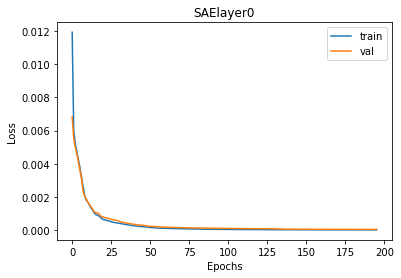

(194042, 512)


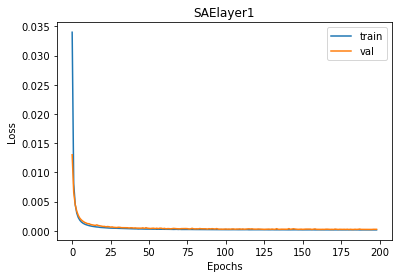

(194042, 256)


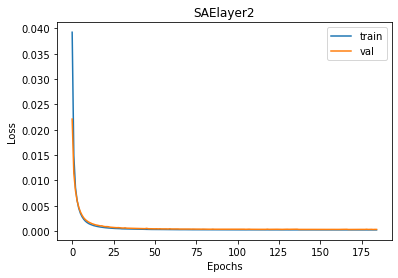

(194042, 128)


In [89]:
for i in range(n_layer):
    input_dim = X_train.shape[1]
    latent_dim = layers[i]
    autoencoder = Autoencoder(latent_dim, input_dim) 
    autoencoder.compile(loss=losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(lr=lr))

    hist = autoencoder.fit(X_train, X_train,
                epochs=1000,
                batch_size = 2048, 
                verbose=0,
                callbacks=[earlystop_callback], 
                validation_data=(X_val, X_val))
    
    plt.plot(hist.history['loss'], label='train')
    plt.plot(hist.history['val_loss'], label='val')

    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    #plt.yscale('log')
    plt.title(experiment + 'layer%s'%(i))
    plt.savefig(plots_folder + 'training and validation loss')
    plt.show()
    
    X_train, X_val = autoencoder.encoder.predict(X_train),autoencoder.encoder.predict(X_val)
    X_test = autoencoder.encoder.predict(X_test)
    print(X_train.shape)

In [90]:
class CustomMultiLossLayer(Layer):
    def __init__(self, nb_outputs, **kwargs):
        self.nb_outputs = nb_outputs # nb_outputs = 2*#meas_steps
        self.is_placeholder = True
        super(CustomMultiLossLayer, self).__init__(**kwargs)
        
    def build(self, input_shape=None):
        # initialise log_vars
        self.log_vars = []
        for i in range(self.nb_outputs):
            self.log_vars += [self.add_weight(name='log_var' + str(i), shape=(1,),
                                              initializer=Constant(0.), trainable=variance_on)]
        super(CustomMultiLossLayer, self).build(input_shape)

    def multi_loss(self, y_true, y_pred, weights):
        loss = 0        
        # cross-entropy part
        for i in range(self.nb_outputs//2):
            
            y_i = y_true[:,2*i:2*i+2]
            y_pred_i = y_pred[:,2*i:2*i+2]
            w_i = weights[2*i:2*i+2]
            # y_pred_i /= tf.reduce_sum(y_pred_i, axis=1, keepdims=True)
            y_pred_i = tf.nn.softmax(y_pred_i,axis=1)
            loss_category = -tf.reduce_mean(y_i*tf.math.log(tf.clip_by_value(y_pred_i,1e-10,1.0)),axis=0)
            loss_category*=w_i
            vw = self.log_vars[2*i:2*i+2]
            p1, p2 = K.exp(-vw[0][0]*2), K.exp(-vw[1][0]*2)
            loss_i = p1*loss_category[0] + vw[0][0] + p2*loss_category[1] + vw[1][0]
            
            # sigma = self.log_vars[i][0]
            # loss_i = K.exp(-sigma*2)*loss_category[0] + sigma + K.exp(-sigma*2)*loss_category[1] + sigma
            # loss_i = K.exp(-2*sigma)*tf.reduce_sum(loss_category) + sigma
            # loss_i += (p1+p2)*1e-10
            
            loss += loss_i
        
        return loss

    def call(self, inputs, weights):
        y_true = inputs[0]
        y_pred = inputs[1]
        loss = self.multi_loss(y_true, y_pred, weights)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return y_pred

In [91]:
def get_classifier_model(inp_dim, out_dim, weights, dff, rate):
    inp = Input(shape=(inp_dim,))
    final_layer = tf.keras.Sequential([Dense(dff, activation='sigmoid',
                                activity_regularizer=activity_regularizer, kernel_regularizer=kernel_regularizer),
                                tf.keras.layers.Dropout(rate),
                                Dense(dff, activation='sigmoid',
                                activity_regularizer=activity_regularizer, kernel_regularizer=kernel_regularizer),
                                tf.keras.layers.Dropout(rate),
                                tf.keras.layers.Dense(out_dim, activation='sigmoid',
                                activity_regularizer=activity_regularizer, kernel_regularizer=kernel_regularizer)])
    y_pred = final_layer(inp)
    
    y_true = Input(shape=(out_dim,), name='y_true')
    out = CustomMultiLossLayer(nb_outputs=out_dim)([y_true, y_pred],weights)
    return Model([inp, y_true], out)

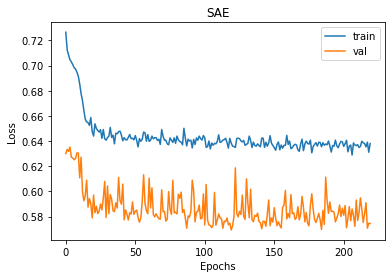

In [92]:
classifier = get_classifier_model(inp_dim = X_train.shape[1], out_dim=label_train.shape[1],
                                  weights=class_weight, dff=dff, rate=dropout_rate)
classifier.compile(loss=None, optimizer=tf.keras.optimizers.Adam(lr=lr))
hist = classifier.fit([X_train, label_train],label_train,
                    epochs=epochs,
                    batch_size = batch_size, 
                    verbose=0,
                    callbacks=[earlystop_callback],
                    validation_data=([X_val,label_val], label_val))
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='val')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.yscale('log')
plt.title(experiment)
plt.show()

In [100]:
from sklearn.metrics import roc_curve,roc_auc_score
import matplotlib.pyplot as plt
def plot_roc_cur(fper, tper, title):  
    plt.plot(fper, tper, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-' + title)
    plt.legend()
    # plt.savefig(plots_folder + 'roc.png')
    plt.show()
    
    
def evaluate(classifier, X, label, label_cols, model_name, split_name, plot=False, save=True):
    thresh = 0.5
    label_pred = classifier.predict([X,label])
    label_true = label
    
    # softmax for pos/neg predictions
    for i in range(label_true.shape[1]//2):
        label_pred[:,2*i:2*i+2] = tf.nn.softmax(label_pred[:,2*i:2*i+2],axis=1)
        
    
    prob = label_pred*label_true
    
    print(split_name, ': the overall accuracy is:', sum(sum(prob.numpy()>thresh))/sum(sum(label.numpy()>0)))
    print(split_name, ': the overall recall is:', sum(sum(prob.numpy()>thresh)[1::2])/sum(sum(label.numpy()>0)[1::2]))
    
    meas_steps = label_cols
    result = pd.DataFrame(index=meas_steps, columns = ['model', 'split', 'tp','tn','fn','fp','tpr','fpr','min_dis', 'auc'])
    for i in range(len(meas_steps)):
        neg = prob[:,2*i]
        pos = prob[:,2*i+1]

        pos = pos[pos!=0].numpy()
        neg = neg[neg!=0].numpy()

        tp = sum(pos>thresh)
        fn = sum(pos<thresh)
        tn = sum(neg>thresh)
        fp = sum(neg<thresh)
        tpr = tp/(tp+fn+1e-9)
        fpr = fp/(fp+tn+1e-9)

        y_prob = np.append(pos, neg)
        y_true = np.append([1]*len(pos), [0]*len(neg))
        if len(pos) and len(neg):
            fper, tper, thresholds = roc_curve(np.append([1]*len(pos), [0]*len(neg)),np.append(pos, 1-neg))
            auc = roc_auc_score(np.append([1]*len(pos), [0]*len(neg)),np.append(pos, 1-neg))
            min_dis = np.sqrt(fper**2 + (1-tper)**2).min()
        else:
            min_dis = None
            auc = None
        result.iloc[i] = [model_name,split_name,tp,tn,fn,fp,tpr,fpr,min_dis,auc]
        if plot:
            plot_roc_cur(fper, tper, meas_steps[i])
    display(result)

In [101]:
evaluate(classifier, X_train, label_train, label_cols, model_name, 'train', plot=False)
evaluate(classifier, X_val, label_val, label_cols, model_name, 'val', plot=False)
evaluate(classifier, X_test, label_test, label_cols, model_name, 'test', plot=False)

train : the overall accuracy is: 0.7914223243819027
train : the overall recall is: 0.6443925233644859


,model,split,tp,tn,fn,fp,tpr,fpr,min_dis,auc
0,"SAE[512, 256, 128]",train,189,6020,83,0,0.694853,0,0.272637,0.864685
1,"SAE[512, 256, 128]",train,29,6890,4,3398,0.878788,0.330288,0.288979,0.84666
2,"SAE[512, 256, 128]",train,115,40481,85,2508,0.575,0.0583405,0.376547,0.792516
3,"SAE[512, 256, 128]",train,82,8181,50,2933,0.621212,0.263901,0.398215,0.740557
4,"SAE[512, 256, 128]",train,258,24540,170,8254,0.602804,0.251692,0.450492,0.759567
5,"SAE[512, 256, 128]",train,419,56241,290,7766,0.590973,0.12133,0.395448,0.768232
6,"SAE[512, 256, 128]",train,1140,80218,562,37114,0.6698,0.316316,0.456005,0.73483
7,"SAE[512, 256, 128]",train,347,1065,96,683,0.783296,0.390732,0.422325,0.725592
8,"SAE[512, 256, 128]",train,37,20929,49,1491,0.430233,0.0665031,0.480877,0.718747
9,"SAE[512, 256, 128]",train,24,7864,24,10,0.5,0.00127,0.253773,0.84753


val : the overall accuracy is: 0.8199823943661971
val : the overall recall is: 0.5135802469135803


,model,split,tp,tn,fn,fp,tpr,fpr,min_dis,auc
0,"SAE[512, 256, 128]",val,0,1417,13,0,0,0,0.677095,0.463167
1,"SAE[512, 256, 128]",val,1,1013,4,496,0.2,0.328694,0.682246,0.438038
2,"SAE[512, 256, 128]",val,36,7113,7,682,0.837209,0.087492,0.172983,0.882474
3,"SAE[512, 256, 128]",val,20,1176,3,418,0.869565,0.262233,0.259498,0.843053
4,"SAE[512, 256, 128]",val,29,3529,62,754,0.318681,0.176045,0.485651,0.653334
5,"SAE[512, 256, 128]",val,41,10624,27,1209,0.602941,0.102172,0.347753,0.74458
6,"SAE[512, 256, 128]",val,232,14564,250,5099,0.481328,0.25932,0.526237,0.647708
7,"SAE[512, 256, 128]",val,39,151,0,45,1,0.229592,0.214286,0.843799
8,"SAE[512, 256, 128]",val,4,4092,2,133,0.666667,0.0314793,0.185491,0.815976
9,"SAE[512, 256, 128]",val,0,1788,4,0,0,0,0.661721,0.291387


test : the overall accuracy is: 0.7733752114037207
test : the overall recall is: 0.4828711256117455


,model,split,tp,tn,fn,fp,tpr,fpr,min_dis,auc
0,"SAE[512, 256, 128]",test,0,891,10,0,0,0,0.661918,0.509203
1,"SAE[512, 256, 128]",test,1,661,1,289,0.5,0.304211,0.437895,0.769474
2,"SAE[512, 256, 128]",test,35,4798,13,616,0.729167,0.113779,0.24796,0.804631
3,"SAE[512, 256, 128]",test,30,1642,3,347,0.909091,0.17446,0.177567,0.918674
4,"SAE[512, 256, 128]",test,13,2348,36,1219,0.265306,0.341744,0.741627,0.472626
5,"SAE[512, 256, 128]",test,29,7683,57,1440,0.337209,0.157843,0.622153,0.582723
6,"SAE[512, 256, 128]",test,152,11408,165,5567,0.479495,0.327953,0.6121,0.61088
7,"SAE[512, 256, 128]",test,5,840,3,135,0.625,0.138462,0.355897,0.809872
8,"SAE[512, 256, 128]",test,4,2759,8,147,0.333333,0.050585,0.450765,0.687056
9,"SAE[512, 256, 128]",test,0,1150,5,1,0,0.00086881,0.249662,0.680799


# 3. QAE

In [102]:
import tensorflow as tf
import numpy as np
import pandas as pd
from math import exp
import time
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda, Layer, Dropout
from tensorflow.keras.initializers import Constant
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import pytz
from datetime import datetime
import os
import csv
import sys
from scipy.stats import mode
import matplotlib.pyplot as plt

In [103]:
layers = [512,256,128]
n_layer = len(layers)
dff = 128
dropout_rate = 0.5
model_name = 'QAE' + str(layers)
activation='sigmoid'

earlystop_callback = tf.keras.callbacks.EarlyStopping(
  monitor='val_loss', min_delta=0.0001,
  patience=100,restore_best_weights=True)

reg_kernal, reg_activity = 1e-4,1e-4
kernel_regularizer=tf.keras.regularizers.l2(reg_kernal)
activity_regularizer=tf.keras.regularizers.l2(reg_activity)
#kernel_regularizer=None
activity_regularizer=None
lr = 0.005

epochs = 1000
batch_size = 2048
model_name

'QAE[512, 256, 128]'

## read and process the data

In [104]:
experiment = 'QAE'

In [105]:
np_path = 'npdata/%s/'%(tool_set)
X_train = np.load(np_path+'X_train.npy')
X_val = np.load(np_path+'X_val.npy')
X_test = np.load(np_path+'X_test.npy')
label_train = np.load(np_path+'label_train.npy')
label_val = np.load(np_path+'label_val.npy')
label_test = np.load(np_path+'label_test.npy')
label_cols = np.array(range(label_train.shape[1]//2))

X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_val = tf.convert_to_tensor(X_val, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
label_train = tf.convert_to_tensor(label_train, dtype=tf.float32)
label_val = tf.convert_to_tensor(label_val, dtype=tf.float32)
label_test = tf.convert_to_tensor(label_test, dtype=tf.float32)

In [106]:
X_train = tf.reshape(X_train, [X_train.shape[0], X_train.shape[1]*X_train.shape[2]])
X_val = tf.reshape(X_val, [X_val.shape[0], X_val.shape[1]*X_val.shape[2]])
X_test = tf.reshape(X_test, [X_test.shape[0], X_test.shape[1]*X_test.shape[2]])

In [107]:
print(X_train.shape, X_val.shape, X_test.shape)
print(label_train.shape, label_val.shape, label_test.shape)

(194042, 1634) (34122, 1634) (27326, 1634)
(194042, 22) (34122, 22) (27326, 22)


In [108]:
class_weight = np.array([label_train.shape[0]/label_train.shape[1]/label_train.numpy()[:,i].sum() for i in range(label_train.shape[1])])

class_weight

array([1.46513138e+00, 3.24268048e+01, 8.57318323e-01, 2.67275482e+02,
       2.05170879e-01, 4.41004545e+01, 7.93601845e-01, 6.68188705e+01,
       2.68954410e-01, 2.06076890e+01, 1.37798849e-01, 1.24401846e+01,
       7.51720836e-02, 5.18219207e+00, 5.04581860e+00, 1.99099118e+01,
       3.93402806e-01, 1.02559197e+02, 1.12015379e+00, 1.83751894e+02,
       2.45863046e-01, 3.88550260e+01])

In [109]:
class CustomMultiLossLayer(Layer):
    def __init__(self, nb_outputs=2, **kwargs):
        self.nb_outputs = nb_outputs # nb_outputs = 2*#meas_steps+1
        self.is_placeholder = True
        super(CustomMultiLossLayer, self).__init__(**kwargs)
        
    def build(self, input_shape=None):
        # initialise log_vars
        self.log_vars = []
        for i in range(self.nb_outputs):
            self.log_vars += [self.add_weight(name='log_var' + str(i), shape=(1,),
                                              initializer=Constant(0.), trainable=variance_on)]
        super(CustomMultiLossLayer, self).build(input_shape)

    def multi_loss(self, ys_true, ys_pred, weights):
        assert len(ys_true) == 2 and len(ys_pred) == 2
        loss = 0
        # 1 for mse and 2 for crossentropy
        y1_true, y2_true = ys_true
        y1_pred, y2_pred = ys_pred
        
        assert y2_pred.shape[1] == self.nb_outputs-1 and y2_true.shape[1] == self.nb_outputs-1
        
        # mse part
        log_var1 = self.log_vars[0] # log_var = log(sigma^2)
        p1 = K.exp(-log_var1[0]*2)
        loss += 0.5*p1 * tf.keras.losses.mean_squared_error(y1_true, y1_pred) + log_var1[0]
        
        # cross-entropy part
        for i in range((self.nb_outputs-1)//2):
            
            y_i = y2_true[:,2*i:2*i+2]
            y_pred_i = y2_pred[:,2*i:2*i+2]
            w_i = weights[2*i:2*i+2]
            vw = self.log_vars[2*i+1:2*i+3]
            p1, p2 = K.exp(-vw[0][0]*2), K.exp(-vw[1][0]*2), 
            #y_pred_i /= tf.reduce_sum(y_pred_i, axis=1, keepdims=True)
            y_pred_i = tf.nn.softmax(y_pred_i,axis=1)
            loss_category = -tf.reduce_mean(y_i*tf.math.log(tf.clip_by_value(y_pred_i,1e-10,1.0)),axis=0)
            loss_category*=w_i
            loss_i = p1*loss_category[0] + vw[0][0] + p2*loss_category[1] + vw[1][0]
            
            loss += loss_i
        
        return loss
        
        #for y_true, y_pred, log_var in zip(ys_true, ys_pred, self.log_vars):
        #    precision = K.exp(-log_var[0])
        #    loss += K.sum(precision * (y_true - y_pred)**2. + log_var[0], -1)
        #return K.mean(loss)

    def call(self, x, inputs, weights):
        ys_true = inputs[:2]
        ys_pred = inputs[2:]
        loss = self.multi_loss(ys_true, ys_pred, weights)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return x
    
class CustomMultiLossLayer2(Layer):
    def __init__(self, nb_outputs=2, **kwargs):
        self.nb_outputs = nb_outputs # nb_outputs = 2*#meas_steps
        self.is_placeholder = True
        super(CustomMultiLossLayer2, self).__init__(**kwargs)
        
    def build(self, input_shape=None):
        # initialise log_vars
        self.log_vars = []
        for i in range(self.nb_outputs):
            self.log_vars += [self.add_weight(name='log_var' + str(i), shape=(1,),
                                              initializer=Constant(0.), trainable=variance_on)]
        super(CustomMultiLossLayer2, self).build(input_shape)

    def multi_loss(self, y_true, y_pred, weights):
        loss = 0        
        # cross-entropy part
        for i in range(self.nb_outputs//2):
            
            y_i = y_true[:,2*i:2*i+2]
            y_pred_i = y_pred[:,2*i:2*i+2]
            w_i = weights[2*i:2*i+2]
            vw = self.log_vars[2*i:2*i+2]
            p1, p2 = K.exp(-vw[0][0]*2), K.exp(-vw[1][0]*2), 
            #y_pred_i /= tf.reduce_sum(y_pred_i, axis=1, keepdims=True)
            y_pred_i = tf.nn.softmax(y_pred_i,axis=1)
            loss_category = -tf.reduce_mean(y_i*tf.math.log(tf.clip_by_value(y_pred_i,1e-10,1.0)),axis=0)
            loss_category*=w_i
            loss_i = p1*loss_category[0] + vw[0][0] + p2*loss_category[1] + vw[1][0]
            
            loss += loss_i
        
        return loss

    def call(self, inputs,weights):
        y_true = inputs[0]
        y_pred = inputs[1]
        loss = self.multi_loss(y_true, y_pred, weights)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return y_pred

In [110]:
def get_qae_model(nb_features, Q, D1, D2, weights):
    inp = Input(shape=(Q,), name='inp')
    x = Dense(nb_features, activation=activation)(inp)
    #x = Dropout(0.2)(x)
    y1_pred = Dense(D1,activation='sigmoid')(x)
    y2_pred = Dense(D2,activation='sigmoid')(x)
    # y1_true = Input(shape=(D1,), name='y1_true')
    y2_true = Input(shape=(D2,), name='y2_true')
    out = CustomMultiLossLayer(nb_outputs=D2+1)(x, [inp, y2_true, y1_pred, y2_pred],weights)
    return Model([inp, y2_true], out)

def get_classifier_model(inp_dim, out_dim, weights, dff, rate):
    inp = Input(shape=(inp_dim,))
    final_layer = tf.keras.Sequential([Dense(dff, activation='sigmoid',
                                activity_regularizer=activity_regularizer, kernel_regularizer=kernel_regularizer),
                                tf.keras.layers.Dropout(rate),
                                Dense(dff, activation='sigmoid',
                                activity_regularizer=activity_regularizer, kernel_regularizer=kernel_regularizer),
                                tf.keras.layers.Dropout(rate),
                                tf.keras.layers.Dense(out_dim, activation='sigmoid',
                                activity_regularizer=activity_regularizer, kernel_regularizer=kernel_regularizer)])
    y_pred = final_layer(inp)
    
    y_true = Input(shape=(out_dim,), name='y_true')
    out = CustomMultiLossLayer2(nb_outputs=out_dim)([y_true, y_pred],weights)
    return Model([inp, y_true], out)

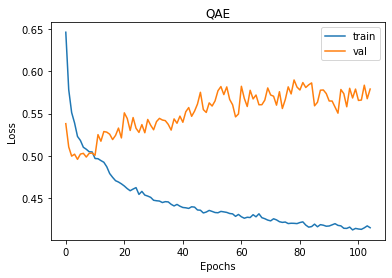

training set shapes: (194042, 512) (194042, 22)


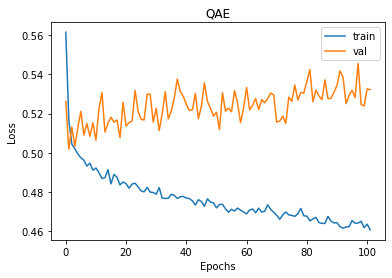

training set shapes: (194042, 256) (194042, 22)


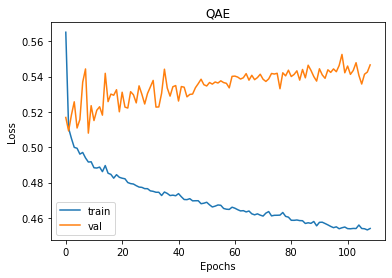

training set shapes: (194042, 128) (194042, 22)
CPU times: user 11min 18s, sys: 44.8 s, total: 12min 3s
Wall time: 5min 21s


In [111]:
%%time

for i in range(n_layer): 
    nb_features = layers[i]
    Q = X_test.shape[1]
    D1 = Q
    D2 = label_test.shape[1]
    
    K.clear_session()   
    qae = get_qae_model(nb_features, Q, D1, D2,class_weight)
    qae.compile(optimizer=tf.keras.optimizers.Adam(lr=lr), loss=None)
  
    hist = qae.fit([X_train, label_train],
                epochs=epochs,
                batch_size = batch_size, 
                verbose=0,
                callbacks=[earlystop_callback],
                validation_data=([X_val, label_val], None))
    plt.plot(hist.history['loss'], label='train')
    plt.plot(hist.history['val_loss'], label='val')

    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    #plt.yscale('log')
    plt.title(experiment)
    plt.show()
    
    X_train = qae.predict([X_train, label_train], batch_size=batch_size)
    X_val =  qae.predict([X_val, label_val], batch_size=batch_size)
    X_test = qae.predict([X_test, label_test], batch_size=batch_size)
    print('training set shapes:', X_train.shape, label_train.shape)

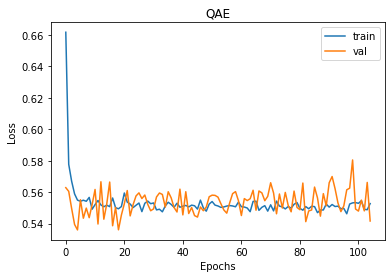

In [112]:
classifier = get_classifier_model(inp_dim = X_train.shape[1], out_dim=label_train.shape[1],weights=class_weight, dff=dff, rate=dropout_rate)
classifier.compile(loss=None, optimizer=tf.keras.optimizers.Adam(lr=lr))
hist = classifier.fit([X_train, label_train],label_train,
                    epochs=epochs,
                    batch_size = batch_size, 
                    verbose=0,
                    callbacks=[earlystop_callback],
                    validation_data=([X_val,label_val], label_val))
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='val')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.yscale('log')
plt.title(experiment)
plt.show()

In [113]:
evaluate(classifier, X_train, label_train, label_cols, model_name, 'train', plot=False)
evaluate(classifier, X_val, label_val, label_cols, model_name, 'val', plot=False)
evaluate(classifier, X_test, label_test, label_cols, model_name, 'test', plot=False)

train : the overall accuracy is: 0.7787436228065258
train : the overall recall is: 0.7703271028037383


,model,split,tp,tn,fn,fp,tpr,fpr,min_dis,auc
0,"QAE[512, 256, 128]",train,205,5692,67,328,0.753676,0.054485,0.23588,0.897479
1,"QAE[512, 256, 128]",train,27,9071,6,1217,0.818182,0.118293,0.212219,0.897607
2,"QAE[512, 256, 128]",train,141,40083,59,2906,0.705,0.0675987,0.293592,0.829792
3,"QAE[512, 256, 128]",train,109,8533,23,2581,0.825758,0.23223,0.26145,0.881991
4,"QAE[512, 256, 128]",train,383,26160,45,6634,0.89486,0.202293,0.216629,0.894073
5,"QAE[512, 256, 128]",train,503,53768,206,10239,0.70945,0.159967,0.323099,0.846211
6,"QAE[512, 256, 128]",train,1289,81037,413,36295,0.757344,0.309336,0.387323,0.805514
7,"QAE[512, 256, 128]",train,332,1423,111,325,0.749436,0.185927,0.307306,0.797259
8,"QAE[512, 256, 128]",train,57,20044,29,2376,0.662791,0.105977,0.275955,0.887645
9,"QAE[512, 256, 128]",train,45,5182,3,2692,0.9375,0.341885,0.190316,0.907007


val : the overall accuracy is: 0.8340342983828899
val : the overall recall is: 0.6148148148148148


,model,split,tp,tn,fn,fp,tpr,fpr,min_dis,auc
0,"QAE[512, 256, 128]",val,3,1372,10,45,0.230769,0.0317572,0.472964,0.692661
1,"QAE[512, 256, 128]",val,1,1371,4,138,0.2,0.0914513,0.753168,0.370974
2,"QAE[512, 256, 128]",val,35,7402,8,393,0.813953,0.0504169,0.165106,0.889312
3,"QAE[512, 256, 128]",val,20,1362,3,232,0.869565,0.145546,0.172786,0.903592
4,"QAE[512, 256, 128]",val,56,3611,35,672,0.615385,0.156899,0.396057,0.712016
5,"QAE[512, 256, 128]",val,41,10056,27,1777,0.602941,0.150173,0.320812,0.795467
6,"QAE[512, 256, 128]",val,271,15346,211,4317,0.562241,0.219549,0.428067,0.723695
7,"QAE[512, 256, 128]",val,39,159,0,37,1,0.188776,0.188776,0.88383
8,"QAE[512, 256, 128]",val,5,3900,1,325,0.833333,0.0769231,0.167963,0.863274
9,"QAE[512, 256, 128]",val,0,1598,4,190,0,0.106264,0.33613,0.779782


test : the overall accuracy is: 0.761737939921076
test : the overall recall is: 0.4812398042414356


,model,split,tp,tn,fn,fp,tpr,fpr,min_dis,auc
0,"QAE[512, 256, 128]",test,1,853,9,38,0.1,0.0426487,0.420591,0.700112
1,"QAE[512, 256, 128]",test,1,816,1,134,0.5,0.141053,0.500217,0.504211
2,"QAE[512, 256, 128]",test,39,4725,9,689,0.8125,0.127263,0.218086,0.806947
3,"QAE[512, 256, 128]",test,18,1743,15,246,0.545455,0.12368,0.183019,0.888599
4,"QAE[512, 256, 128]",test,11,2886,38,681,0.22449,0.190917,0.523898,0.549624
5,"QAE[512, 256, 128]",test,34,7008,52,2115,0.395349,0.231832,0.633442,0.491718
6,"QAE[512, 256, 128]",test,149,11759,168,5216,0.470032,0.307275,0.558739,0.643292
7,"QAE[512, 256, 128]",test,5,846,3,129,0.625,0.132308,0.385709,0.806923
8,"QAE[512, 256, 128]",test,4,2507,8,399,0.333333,0.137302,0.23782,0.799094
9,"QAE[512, 256, 128]",test,4,967,1,184,0.8,0.159861,0.161599,0.840487


# 4. LSTM

In [114]:
import tensorflow as tf
import numpy as np
import pandas as pd
from math import exp
import time
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda, Layer, Dropout
from tensorflow.keras.initializers import Constant
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import pytz
from datetime import datetime
import os
import csv
import sys
from scipy.stats import mode
import matplotlib.pyplot as plt

In [115]:
layers = [512,256,128]
n_layer = len(layers)
dff = 128
dropout_rate = 0.5
model_name = 'LSTM' + str(layers)


earlystop_callback = tf.keras.callbacks.EarlyStopping(
  monitor='val_loss', min_delta=0.0001,
  patience=100,restore_best_weights=True)

reg_kernal, reg_activity = 1e-4,1e-4
kernel_regularizer=tf.keras.regularizers.l2(reg_kernal)
activity_regularizer=tf.keras.regularizers.l2(reg_activity)
#kernel_regularizer=None
activity_regularizer=None
lr = 0.005

epochs = 1000
batch_size = 2048
model_name

'LSTM[512, 256, 128]'

## read and process the data

In [116]:
experiment = 'LSTM'

In [128]:
np_path = 'npdata/%s/'%(tool_set)
X_train = np.load(np_path+'X_train.npy')
X_val = np.load(np_path+'X_val.npy')
X_test = np.load(np_path+'X_test.npy')
label_train = np.load(np_path+'label_train.npy')
label_val = np.load(np_path+'label_val.npy')
label_test = np.load(np_path+'label_test.npy')
label_cols = np.array(range(label_train.shape[1]//2))

X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_val = tf.convert_to_tensor(X_val, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
label_train = tf.convert_to_tensor(label_train, dtype=tf.float32)
label_val = tf.convert_to_tensor(label_val, dtype=tf.float32)
label_test = tf.convert_to_tensor(label_test, dtype=tf.float32)

In [118]:
print(X_train.shape, X_val.shape, X_test.shape)
print(label_train.shape, label_val.shape, label_test.shape)

(194042, 2, 817) (34122, 2, 817) (27326, 2, 817)
(194042, 22) (34122, 22) (27326, 22)


In [119]:
class_weight = np.array([label_train.shape[0]/label_train.shape[1]/label_train.numpy()[:,i].sum() for i in range(label_train.shape[1])])

class_weight

array([1.46513138e+00, 3.24268048e+01, 8.57318323e-01, 2.67275482e+02,
       2.05170879e-01, 4.41004545e+01, 7.93601845e-01, 6.68188705e+01,
       2.68954410e-01, 2.06076890e+01, 1.37798849e-01, 1.24401846e+01,
       7.51720836e-02, 5.18219207e+00, 5.04581860e+00, 1.99099118e+01,
       3.93402806e-01, 1.02559197e+02, 1.12015379e+00, 1.83751894e+02,
       2.45863046e-01, 3.88550260e+01])

In [120]:
def loss_func(w):
    def inner_loss(y,y_pred):
        loss = 0
        weights = w
        
        for i in range(len(weights)//2):
            
            y_i = y[:,2*i:2*i+2]
            y_pred_i = y_pred[:,2*i:2*i+2]
            w_i = weights[2*i:2*i+2]
            #y_pred_i /= tf.reduce_sum(y_pred_i, axis=1, keepdims=True)
            y_pred_i = tf.nn.softmax(y_pred_i,axis=1)
            loss_category = -tf.reduce_mean(y_i*tf.math.log(tf.clip_by_value(y_pred_i,1e-10,1.0)),axis=0)
            loss_i = tf.reduce_sum(loss_category*w_i)
            
            loss += loss_i

        return loss
    return inner_loss

In [121]:
class CustomMultiLossLayer(Layer):
    def __init__(self, nb_outputs, **kwargs):
        self.nb_outputs = nb_outputs # nb_outputs = 2*#meas_steps
        self.is_placeholder = True
        super(CustomMultiLossLayer, self).__init__(**kwargs)
        
    def build(self, input_shape=None):
        # initialise log_vars
        self.log_vars = []
        for i in range(self.nb_outputs):
            self.log_vars += [self.add_weight(name='log_var' + str(i), shape=(1,),
                                              initializer=Constant(0.), trainable=variance_on)]
        super(CustomMultiLossLayer, self).build(input_shape)

    def multi_loss(self, y_true, y_pred, weights):
        loss = 0        
        # cross-entropy part
        for i in range(self.nb_outputs//2):
            
            y_i = y_true[:,2*i:2*i+2]
            y_pred_i = y_pred[:,2*i:2*i+2]
            w_i = weights[2*i:2*i+2]
            # y_pred_i /= tf.reduce_sum(y_pred_i, axis=1, keepdims=True)
            y_pred_i = tf.nn.softmax(y_pred_i,axis=1)
            loss_category = -tf.reduce_mean(y_i*tf.math.log(tf.clip_by_value(y_pred_i,1e-10,1.0)),axis=0)
            loss_category*=w_i
            vw = self.log_vars[2*i:2*i+2]
            p1, p2 = K.exp(-vw[0][0]*2), K.exp(-vw[1][0]*2)
            loss_i = p1*loss_category[0] + vw[0][0] + p2*loss_category[1] + vw[1][0]
            
            # sigma = self.log_vars[i][0]
            # loss_i = K.exp(-sigma*2)*loss_category[0] + sigma + K.exp(-sigma*2)*loss_category[1] + sigma
            # loss_i = K.exp(-2*sigma)*tf.reduce_sum(loss_category) + sigma
            # loss_i += (p1+p2)*1e-10
            
            loss += loss_i
        
        return loss

    def call(self, inputs, weights):
        y_true = inputs[0]
        y_pred = inputs[1]
        loss = self.multi_loss(y_true, y_pred, weights)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return y_pred

In [122]:
def get_classifier_model(inp_dim1, inp_dim2, out_dim, weights, dff, rate):
    inp = Input(shape=(inp_dim1,inp_dim2))
    final_layer = tf.keras.Sequential([tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(dff)),
                                       Dense(dff, activation='sigmoid',
                                       activity_regularizer=activity_regularizer, kernel_regularizer=kernel_regularizer),
                                       tf.keras.layers.Dropout(rate),
                                       Dense(dff, activation='sigmoid',
                                       activity_regularizer=activity_regularizer, kernel_regularizer=kernel_regularizer),
                                       tf.keras.layers.Dropout(rate),
                                       tf.keras.layers.Dense(out_dim, activation='sigmoid',
                                       activity_regularizer=activity_regularizer, kernel_regularizer=kernel_regularizer)])
    y_pred = final_layer(inp)
    
    y_true = Input(shape=(out_dim,), name='y_true')
    out = CustomMultiLossLayer(nb_outputs=out_dim)([y_true, y_pred],weights)
    return Model([inp, y_true], out)

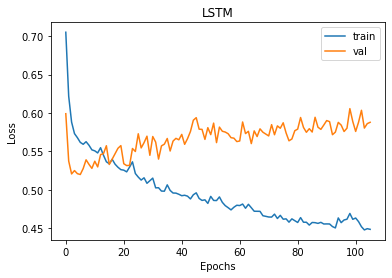

In [123]:
classifier = get_classifier_model(inp_dim1 = X_train.shape[1],inp_dim2 = X_train.shape[2], out_dim=label_train.shape[1],
                                  weights=class_weight, dff=dff, rate=dropout_rate)
classifier.compile(loss=None, optimizer=tf.keras.optimizers.Adam(lr=lr))
hist = classifier.fit([X_train, label_train],label_train,
                    epochs=epochs,
                    batch_size = batch_size, 
                    verbose=0,
                    callbacks=[earlystop_callback],
                    validation_data=([X_val,label_val], label_val))
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='val')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.yscale('log')
plt.title(experiment)
plt.savefig(plots_folder + 'training and validation loss')
plt.show()

In [100]:
from sklearn.metrics import roc_curve,roc_auc_score
import matplotlib.pyplot as plt
def plot_roc_cur(fper, tper, title):  
    plt.plot(fper, tper, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-' + title)
    plt.legend()
    # plt.savefig(plots_folder + 'roc.png')
    plt.show()
    
    
def evaluate(classifier, X, label, label_cols, model_name, split_name, plot=False, save=True):
    thresh = 0.5
    label_pred = classifier.predict([X,label])
    label_true = label
    
    # softmax for pos/neg predictions
    for i in range(label_true.shape[1]//2):
        label_pred[:,2*i:2*i+2] = tf.nn.softmax(label_pred[:,2*i:2*i+2],axis=1)
        
    
    prob = label_pred*label_true
    
    print(split_name, ': the overall accuracy is:', sum(sum(prob.numpy()>thresh))/sum(sum(label.numpy()>0)))
    print(split_name, ': the overall recall is:', sum(sum(prob.numpy()>thresh)[1::2])/sum(sum(label.numpy()>0)[1::2]))
    
    meas_steps = label_cols
    result = pd.DataFrame(index=meas_steps, columns = ['model', 'split', 'tp','tn','fn','fp','tpr','fpr','min_dis', 'auc'])
    for i in range(len(meas_steps)):
        neg = prob[:,2*i]
        pos = prob[:,2*i+1]

        pos = pos[pos!=0].numpy()
        neg = neg[neg!=0].numpy()

        tp = sum(pos>thresh)
        fn = sum(pos<thresh)
        tn = sum(neg>thresh)
        fp = sum(neg<thresh)
        tpr = tp/(tp+fn+1e-9)
        fpr = fp/(fp+tn+1e-9)

        y_prob = np.append(pos, neg)
        y_true = np.append([1]*len(pos), [0]*len(neg))
        if len(pos) and len(neg):
            fper, tper, thresholds = roc_curve(np.append([1]*len(pos), [0]*len(neg)),np.append(pos, 1-neg))
            auc = roc_auc_score(np.append([1]*len(pos), [0]*len(neg)),np.append(pos, 1-neg))
            min_dis = np.sqrt(fper**2 + (1-tper)**2).min()
        else:
            min_dis = None
            auc = None
        result.iloc[i] = [model_name,split_name,tp,tn,fn,fp,tpr,fpr,min_dis,auc]
        if plot:
            plot_roc_cur(fper, tper, meas_steps[i])
    display(result)

In [130]:
evaluate(classifier, X_train, label_train, label_cols, model_name, 'train', plot=False)
evaluate(classifier, X_val, label_val, label_cols, model_name, 'val', plot=False)
evaluate(classifier, X_test, label_test, label_cols, model_name, 'test', plot=False)

train : the overall accuracy is: 0.8242137130683411
train : the overall recall is: 0.6967289719626168


,model,split,tp,tn,fn,fp,tpr,fpr,min_dis,auc
0,"LSTM[512, 256, 128]",train,201,5812,71,208,0.738971,0.0345515,0.22841,0.893207
1,"LSTM[512, 256, 128]",train,26,9263,7,1025,0.787879,0.0996306,0.230694,0.865149
2,"LSTM[512, 256, 128]",train,114,41682,86,1307,0.57,0.0304031,0.401052,0.799386
3,"LSTM[512, 256, 128]",train,99,8412,33,2702,0.75,0.243117,0.327668,0.806925
4,"LSTM[512, 256, 128]",train,319,25903,109,6891,0.745327,0.21013,0.325348,0.816656
5,"LSTM[512, 256, 128]",train,392,59612,317,4395,0.552891,0.0686644,0.383442,0.805203
6,"LSTM[512, 256, 128]",train,1236,84843,466,32489,0.726204,0.276898,0.384451,0.796264
7,"LSTM[512, 256, 128]",train,333,1330,110,418,0.751693,0.23913,0.340295,0.744618
8,"LSTM[512, 256, 128]",train,56,19569,30,2851,0.651163,0.127163,0.308892,0.844936
9,"LSTM[512, 256, 128]",train,25,7812,23,62,0.520833,0.00787402,0.201035,0.893547


val : the overall accuracy is: 0.8676643192488263
val : the overall recall is: 0.5740740740740741


,model,split,tp,tn,fn,fp,tpr,fpr,min_dis,auc
0,"LSTM[512, 256, 128]",val,3,1395,10,22,0.230769,0.0155258,0.591531,0.567613
1,"LSTM[512, 256, 128]",val,1,1394,4,115,0.2,0.0762094,0.489971,0.575083
2,"LSTM[512, 256, 128]",val,33,7496,10,299,0.767442,0.0383579,0.216914,0.893347
3,"LSTM[512, 256, 128]",val,20,1243,3,351,0.869565,0.220201,0.202066,0.877898
4,"LSTM[512, 256, 128]",val,30,3653,61,630,0.32967,0.147093,0.394017,0.690649
5,"LSTM[512, 256, 128]",val,41,11020,27,813,0.602941,0.0687062,0.397911,0.761971
6,"LSTM[512, 256, 128]",val,285,16045,197,3618,0.591286,0.184,0.391127,0.751813
7,"LSTM[512, 256, 128]",val,19,162,20,34,0.487179,0.173469,0.22449,0.837389
8,"LSTM[512, 256, 128]",val,5,3707,1,518,0.833333,0.122604,0.17392,0.927929
9,"LSTM[512, 256, 128]",val,0,1778,4,10,0,0.00559284,0.852908,0.213437


test : the overall accuracy is: 0.8201256342111621
test : the overall recall is: 0.39804241435562804


,model,split,tp,tn,fn,fp,tpr,fpr,min_dis,auc
0,"LSTM[512, 256, 128]",test,0,871,10,20,0,0.0224467,0.313411,0.838384
1,"LSTM[512, 256, 128]",test,1,817,1,133,0.5,0.14,0.501515,0.510526
2,"LSTM[512, 256, 128]",test,19,5209,29,205,0.395833,0.0378648,0.198272,0.92307
3,"LSTM[512, 256, 128]",test,11,1695,22,294,0.333333,0.147813,0.193439,0.8446
4,"LSTM[512, 256, 128]",test,11,2713,38,854,0.22449,0.239417,0.784368,0.405909
5,"LSTM[512, 256, 128]",test,29,7998,57,1125,0.337209,0.123315,0.666598,0.482702
6,"LSTM[512, 256, 128]",test,132,12925,185,4050,0.416404,0.238586,0.565812,0.643046
7,"LSTM[512, 256, 128]",test,4,927,4,48,0.5,0.0492308,0.206154,0.894487
8,"LSTM[512, 256, 128]",test,7,2341,5,565,0.583333,0.194425,0.262675,0.786734
9,"LSTM[512, 256, 128]",test,0,1137,5,14,0,0.0121633,0.203302,0.819288


# 5. Plot ROC

In [1]:
from sklearn.metrics import roc_curve,roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
tool = 'P1'
def plot_roc_cur(fper, tper, title):  
    plt.plot(fper, tper, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-' + title)
    plt.legend()
    # plt.savefig(plots_folder + 'roc.png')
    plt.show()
    
    
def evaluate(classifier, X, label, label_cols, model_name, split_name, plot=False, save=True):
    thresh = 0.5
    label_pred = classifier.predict([X,label])
    label_true = label
    for i in range(label_true.shape[1]//2):

        label_pred[:,2*i:2*i+2] = tf.nn.softmax(label_pred[:,2*i:2*i+2],axis=1)
        
    
    prob = label_pred*label_true
    
    print(split_name, ': the overall accuracy is:', sum(sum(prob.numpy()>thresh))/sum(sum(label.numpy()>0)))
    print(split_name, ': the overall recall is:', sum(sum(prob.numpy()>thresh)[1::2])/sum(sum(label.numpy()>0)[1::2]))
    
    meas_steps = [ms.split(':')[0] for ms in label_cols][::2]
    result = pd.DataFrame(index=meas_steps, columns = ['model', 'split', 'tp','tn','fn','fp','tpr','fpr','min_dis', 'auc', 'data_path'])
    for i in range(len(meas_steps)):
        neg = prob[:,2*i]
        pos = prob[:,2*i+1]

        pos = pos[label_true[:,2*i+1]!=0].numpy()
        neg = neg[label_true[:,2*i]!=0].numpy()

        tp = sum(pos>thresh)
        fn = sum(pos<thresh)
        tn = sum(neg>thresh)
        fp = sum(neg<thresh)
        tpr = tp/(tp+fn+1e-9)
        fpr = fp/(fp+tn+1e-9)

        y_prob = np.append(pos, neg)
        y_true = np.append([1]*len(pos), [0]*len(neg))
        if len(pos) and len(neg):
            fper, tper, thresholds = roc_curve(np.append([1]*len(pos), [0]*len(neg)),np.append(pos, 1-neg))
            auc = roc_auc_score(np.append([1]*len(pos), [0]*len(neg)),np.append(pos, 1-neg))
            min_dis = np.sqrt(fper**2 + (1-tper)**2).min()
        else:
            min_dis = None
            auc = None
        result.iloc[i] = [model_name,split_name,tp,tn,fn,fp,tpr,fpr,min_dis,auc,np_path]
        if plot:
            plot_roc_cur(fper, tper, meas_steps[i])
    display(result)

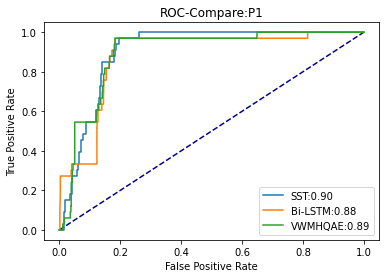

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-Compare:%s'%(tool))
for model in ['SST', 'LSTM', 'QAE']:
    results_folder = '/%s/'%(model)
    
    label_true = np.load(results_folder+'labels_test.np.npy')
    label_pred = np.load(results_folder+'predictions_test.np.npy')
    for i in range(label_true.shape[1]//2):
        label_pred[:,2*i:2*i+2] = tf.nn.softmax(label_pred[:,2*i:2*i+2],axis=1)
        
    
    prob = label_pred*label_true
    i = 3
    neg = prob[:,2*i]
    pos = prob[:,2*i+1]

    pos = pos[label_true[:,2*i+1]!=0]
    neg = neg[label_true[:,2*i]!=0]

    y_prob = np.append(pos, neg)
    y_true = np.append([1]*len(pos), [0]*len(neg))
    fper, tper, thresholds = roc_curve(np.append([1]*len(pos), [0]*len(neg)),np.append(pos, 1-neg))
    auc = roc_auc_score(np.append([1]*len(pos), [0]*len(neg)),np.append(pos, 1-neg))

    if model == 'QAE':
        model = 'VWMHQAE'
    if model == 'LSTM':
        model = 'Bi-LSTM'
    plt.plot(fper, tper, label=model+':' + "%.2f"%(auc))
    
plt.legend()
plt.savefig('roc-%s.png'%(tool))
plt.show()    

In [4]:
from sklearn.metrics import roc_curve,roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
tool = 'P1'
def plot_roc_cur(fper, tper, title):  
    plt.plot(fper, tper, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-' + title)
    plt.legend()
    # plt.savefig(plots_folder + 'roc.png')
    plt.show()
    
    
def evaluate(classifier, X, label, label_cols, model_name, split_name, plot=False, save=True):
    thresh = 0.5
    label_pred = classifier.predict([X,label],batch_size=2048)
    label_true = label
    for i in range(label_true.shape[1]//2):

        label_pred[:,2*i:2*i+2] = tf.nn.softmax(label_pred[:,2*i:2*i+2],axis=1)
        
    
    prob = label_pred*label_true
    
    print(split_name, ': the overall accuracy is:', sum(sum(prob.numpy()>thresh))/sum(sum(label.numpy()>0)))
    print(split_name, ': the overall recall is:', sum(sum(prob.numpy()>thresh)[1::2])/sum(sum(label.numpy()>0)[1::2]))
    
    meas_steps = [ms.split(':')[0] for ms in label_cols][::2]
    result = pd.DataFrame(index=meas_steps, columns = ['model', 'split', 'tp','tn','fn','fp','tpr','fpr','min_dis', 'auc', 'data_path'])
    for i in range(len(meas_steps)):
        neg = prob[:,2*i]
        pos = prob[:,2*i+1]

        pos = pos[label_true[:,2*i+1]!=0].numpy()
        neg = neg[label_true[:,2*i]!=0].numpy()

        tp = sum(pos>thresh)
        fn = sum(pos<thresh)
        tn = sum(neg>thresh)
        fp = sum(neg<thresh)
        tpr = tp/(tp+fn+1e-9)
        fpr = fp/(fp+tn+1e-9)

        y_prob = np.append(pos, neg)
        y_true = np.append([1]*len(pos), [0]*len(neg))
        if len(pos) and len(neg):
            fper, tper, thresholds = roc_curve(np.append([1]*len(pos), [0]*len(neg)),np.append(pos, 1-neg))
            auc = roc_auc_score(np.append([1]*len(pos), [0]*len(neg)),np.append(pos, 1-neg))
            min_dis = np.sqrt(fper**2 + (1-tper)**2).min()
        else:
            min_dis = None
            auc = None
        result.iloc[i] = [model_name,split_name,tp,tn,fn,fp,tpr,fpr,min_dis,auc,np_path]
        if plot:
            plot_roc_cur(fper, tper, meas_steps[i])
    if save and split_name=='test':
        result.to_csv(results_folder + 'result_np.csv', mode='a')
        np.save(results_folder + 'predictions_%s.np'%(split_name),label_pred)
        np.save(results_folder + 'labels_%s.np'%(split_name),label)
        print('saved to', results_folder)
    display(result)

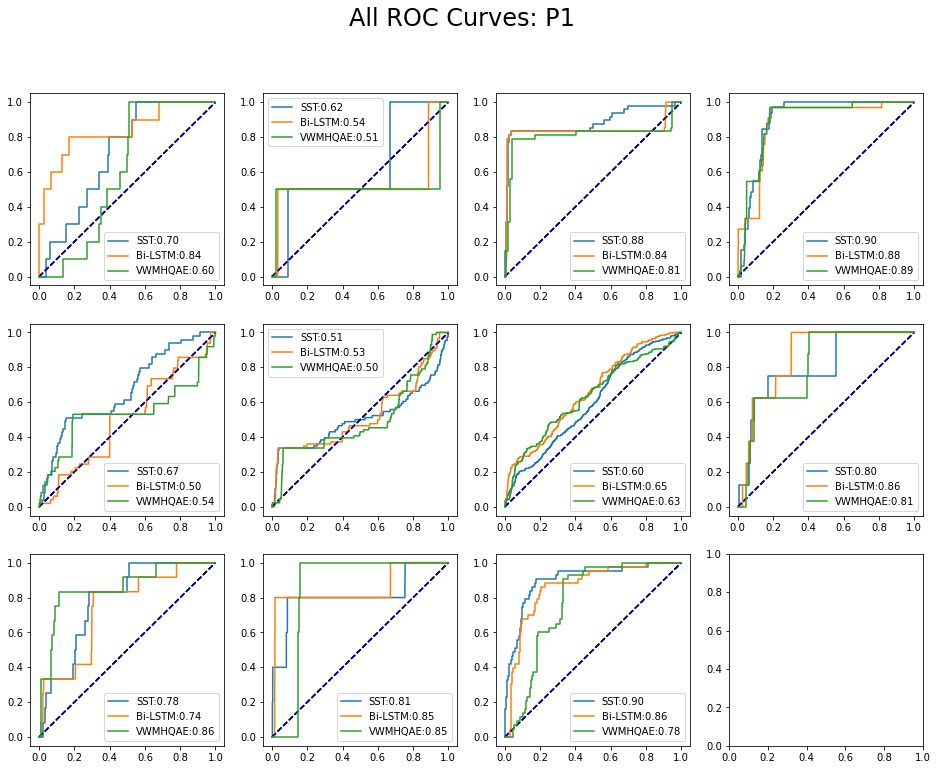

In [5]:
fig, ax = plt.subplots(3,4, figsize=(16, 12))
fig.suptitle('All ROC Curves: %s'%(tool),fontsize=24)

for model in ['SST', 'LSTM', 'QAE']:
    results_folder = 'results/%smod_name/%s/'%(tool_set,model)

    label_true = np.load(results_folder+'labels_test.np.npy')
    label_pred = np.load(results_folder+'predictions_test.np.npy')
    for i in range(label_true.shape[1]//2):
        label_pred[:,2*i:2*i+2] = tf.nn.softmax(label_pred[:,2*i:2*i+2],axis=1)


    prob = label_pred*label_true

    for i in range(prob.shape[1]//2):
        neg = prob[:,2*i]
        pos = prob[:,2*i+1]

        pos = pos[label_true[:,2*i+1]!=0]
        neg = neg[label_true[:,2*i]!=0]

        y_prob = np.append(pos, neg)
        y_true = np.append([1]*len(pos), [0]*len(neg))
        fper, tper, thresholds = roc_curve(np.append([1]*len(pos), [0]*len(neg)),np.append(pos, 1-neg))
        auc = roc_auc_score(np.append([1]*len(pos), [0]*len(neg)),np.append(pos, 1-neg))

        if model == 'QAE':
            model = 'VWMHQAE'
        if model == 'LSTM':
            model = 'Bi-LSTM'
        ax[i//4, i%4].plot([0, 1], [0, 1], color='darkblue', linestyle='--')
        ax[i//4, i%4].plot(fper, tper, label=model+':' + "%.2f"%(auc))
        ax[i//4, i%4].legend()
plt.savefig('rocs-%s.png'%(tool), dpi=600)
